In [3]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import Adam

In [5]:
env = gym.make("ALE/Breakout-v5")
env

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


<TimeLimit<AtariEnv<ALE/Breakout-v5>>>

In [6]:
env.reset()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [7]:
env.reset().shape

(210, 160, 3)

In [8]:
env.step(0)[0].shape

(210, 160, 3)

In [9]:
env.action_space.n

4

In [10]:
env.reward_range

(-inf, inf)

In [11]:
env._max_episode_steps

27000

In [20]:

class Actor:
    def __init__(self,state_shape,total_actions,step_size=0.0001):
        self.input_shape = state_shape
        self.output_shape = total_actions
        self.model = self.theta_NN()
        self.step_size = step_size
        
    def step(self,state):
        action_probs,_ = self.predict_policy_actions(state)
        action = np.random.choice(self.output_shape, 1, p=action_probs.flatten())[0]
        return action
    
    def theta_NN(self):
    
        inputs = keras.Input(shape=self.input_shape)
        x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(inputs)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(self.output_shape, activation="softmax")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())
        return model
    
    def learn(self,samples):
        
        X = []
        y = []
        
        for state,action,delta in samples:
            
            state_f = self.preprocess(state)
            action_probs = self.model.predict(state_f).flatten()
            encoded_action = np.zeros(self.output_shape)
            encoded_action[action] = 1

            gradient = encoded_action - action_probs
            gradient_with_advantage = self.step_size * gradient * delta + action_probs
            gradient_with_advantage = gradient_with_advantage.reshape((1,self.output_shape))

            X.append([state_f])
            y.append(gradient_with_advantage)
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape[0],self.input_shape[1],self.input_shape[2]))
        y = np.reshape(y,(y.shape[0],self.output_shape))
        
        self.model.train_on_batch(X, y)

    def predict_policy_actions(self,state):
        state_f = self.preprocess(state)
        action_probabilities = self.model.predict([state_f],verbose=0)
        optimal_action = np.argmax(action_probabilities)
        
        return action_probabilities, optimal_action
    
    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape[0],self.input_shape[1],self.input_shape[2]))
    
    def test_step(self,state):
        _,action = self.predict_policy_actions(state)
        return action

In [13]:
s = env.reset().shape
a = env.action_space.n
actor = Actor(s,a,)
state = env.reset()
actor.step(state)

2022-11-22 19:13:00.251389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3

In [25]:
class Critic:
    def __init__(self,state_shape,total_actions,step_size=0.0001):
        self.input_shape = state_shape
        self.output_shape = total_actions
        self.model = self.w_NN()
        self.step_size = step_size
    
    def w_NN(self):
        
        inputs = keras.Input(shape=self.input_shape)
        x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(inputs)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(self.output_shape, activation="linear")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())
        return model
    
    def learn(self,samples):
        X = []
        y = []
        
        for state,action,delta in samples:
            
            state_f = self.preprocess(state)
            state_values = np.zeros(self.output_shape)
            state_values[action] = delta
            state_values_f = state_values.reshape((1,self.output_shape))
            X.append([state_f])
            y.append(state_values_f)
            
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape[0],self.input_shape[1],self.input_shape[2]))
        y = np.reshape(y,(y.shape[0],self.output_shape))
        
        self.model.train_on_batch(X, y)

    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape[0],self.input_shape[1],self.input_shape[2]))
    
    def predict_VF_values(self,state):
        state_f = self.preprocess(state)
        action_values = self.model.predict([state_f],verbose=0)
        max_action_value = np.max(action_values)
        state_value = np.mean(action_values)
        
        #return action_values,max_action_value,state_value
        return max_action_value
    

In [26]:
s = env.reset().shape
a = env.action_space.n
critic = Critic(s,a,)
state = env.reset()
critic.predict_VF_values(state)

12.5874815

In [27]:
def main(no_of_episodes = 100,freq_time_steps=5):
    env = gym.make('ALE/Breakout-v5')
    env.reset()
    state_shape = env.reset().shape
    action_shape = env.action_space.n
    
    
    
    actor = Actor(state_shape,action_shape)
    critic = Critic(state_shape,action_shape)
    
    episodes = no_of_episodes
    discount_factor = 0.95
    
    overall_episode_rewards = np.array([])
    overall_time_steps = np.array([])
    samples  = []
    
    for ep in range(1,episodes+1):
        
        state = env.reset()
        #env.render()
        
        episode_reward = 0
        time_step = 1
        train_freq_ts = freq_time_steps
        
        while True:
            
            action = actor.step(state)
            next_state, reward, done, info = env.step(action)
            
            '''
            if time_step > env._max_episode_steps-100:
                reward -= 100
            '''
            #calculate delta
            state_value = critic.predict_VF_values(state)
            next_state_value = critic.predict_VF_values(next_state)
            
            if done:
                next_state_value = 0
            delta = reward + discount_factor*next_state_value - state_value
            samples.append((state,action,delta))
            
            #train every train_freq_ts timesteps
            if(time_step % train_freq_ts == 0):
                critic.learn(samples) #update weights/actor-model-params
                actor.learn(samples)  #update theta/actor-model-params
                samples = []

            state = next_state
            episode_reward += reward
            time_step += 1
            
            if done or time_step > env._max_episode_steps:
                break

        print("Episode:",ep,", return:",episode_reward)
        overall_episode_rewards = np.append(overall_episode_rewards,episode_reward)
        overall_time_steps = np.append(overall_time_steps,time_step)
        
    plt.plot(overall_episode_rewards)
    plt.show()
    plt.plot(overall_time_steps)


1/1 [==============================] - 0s 27ms/step
Episode: 1 , return: 0.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
Episode: 2 , return: 0.0
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step
Episode: 3 , return: 0.0
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step
Episode: 4 , return: 0.0
1/1 [==============================] - 0s 28ms/step
Episode: 5 , return: 0.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step
Episode: 6 , return: 0.0
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step
Episode: 7 , return: 0.0
1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 26ms/step
Episode: 8 , return: 0.0
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step
Episode: 9 , return: 0.0
1/1 [==============================] - 0s 26ms/step
Episode: 10 , return: 0.0


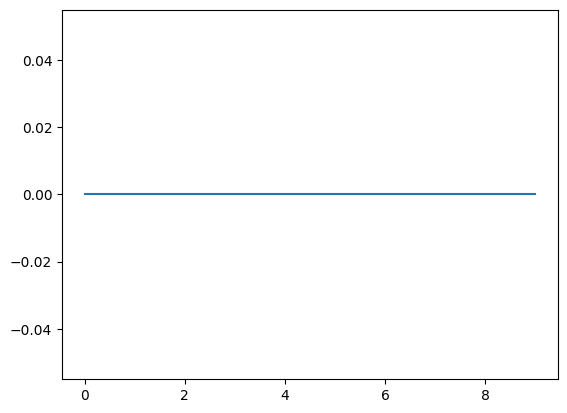

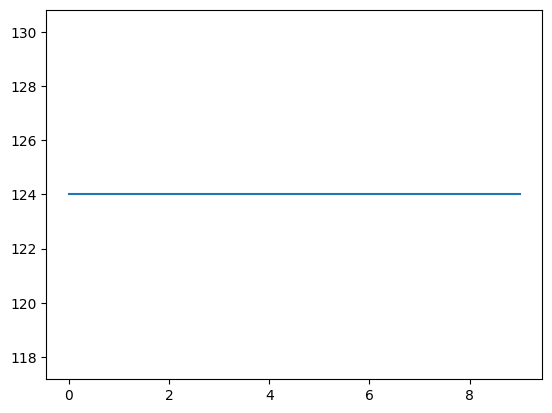

In [28]:
main(10,1)

In [29]:
main(100,1)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 71ms/step


KeyboardInterrupt: 

In [ ]:
main(100,2)

In [ ]:
main(100,5)

In [ ]:
main(200,1)

In [ ]:
main(200,2)

In [ ]:
main(500,2)

In [ ]:
main(1000,2)

In [ ]:
main(1500,2)